# Jupyter Pipeline for Mouse Simulation

### Outputs Time Series Matrix, Time array and SCM vs FCM Spearson Correlation

In [24]:
# A copy of Basic Connectome Simulations, but edited to be nicer.
# Also added the final functionalities of Skeleton Pipeline

# First Import the packages.
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
from scipy import stats
#matplotlib.style.use('ggplot')

## Main adjustments below, can hopefully get away with only changing cell below!

In [25]:
# Main adjustments here:

# Name of import file/zip - Which contains connectivity data.
name = "3_2_BinCon"

# Monitors or not?  (Aka BOLD or not?)
BOLD = True

# Snip is the the number of elements you wish to snip at the start to remove the initial condition effects.
Snip = 10
# Note, if BOLD = False, Snip gets multiplied by 1000. 
if BOLD == False:
    Snip = 1000 * Snip

# Set the Random State/Seed for the Stochastic Integrator:
RandState = 118

# Define the model. 
MODEL = models.WilsonCowan(c_ee=12,c_ei=15,c_ie=10,c_ii=8) 

# models.WilsonCowan(c_ee=np.array([0,11,0,0,0]),c_ei=np.array([0,10,0,0,0]),c_ie=np.array([0,10,0,0,0]),c_ii=np.array([0,11,0,0,0]),b_e=2.5,b_i=3) 

# models.WilsonCowan(c_ee=np.arange(11,19,2),c_ei=10,c_ie=10,c_ii=1,b_e=2.5,b_i=3) 
# models.WilsonCowan(c_ee=np.arange(11,16,1)) 

#models.ReducedWongWang(w=1.0, I_o=0.3)

# models.WilsonCowan()
 
#models.ReducedWongWang(w=1.0, I_o=0.3)

#models.WilsonCowan(r_e=1.0,r_i=1.0,b_e=4.0,b_i=4.0,alpha_e=1.0,alpha_i=2.0,P=0)

In [26]:
# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file("C:\\Users\\Pok Him\\Desktop\\MouseBrainModelling\\Connectomes\\" + name + ".zip")

# Mouse Allen Connectivity
#con = connectivity.Connectivity.from_file("../mouse/allen_2mm/Connectivity.h5")

# Unfortunately, doesn't just pop out like this.  con.weights = con.weights[0:38,0:38]

if BOLD ==  True :
    
    name = name + "_BOLD"

else:
    name = name + "_nonBOLD"

WARNING  File 'hemispheres' not found in ZIP.


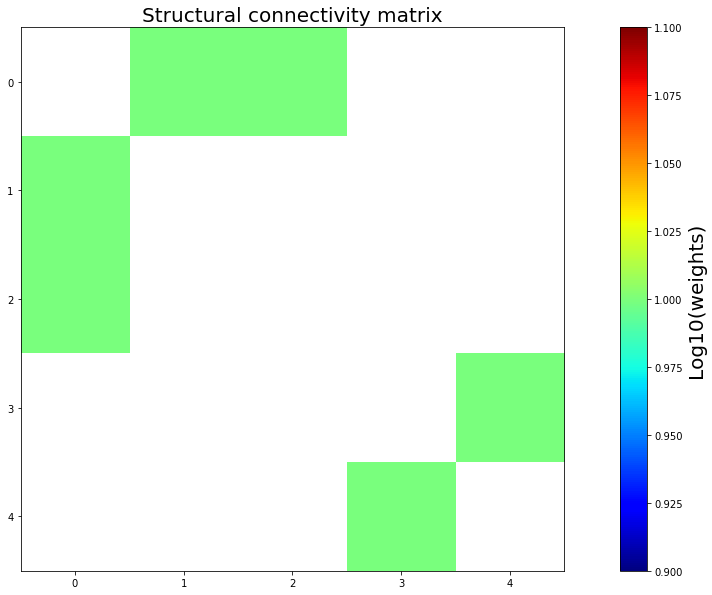

In [27]:
# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
#plt.yticks([0,1,2,3])

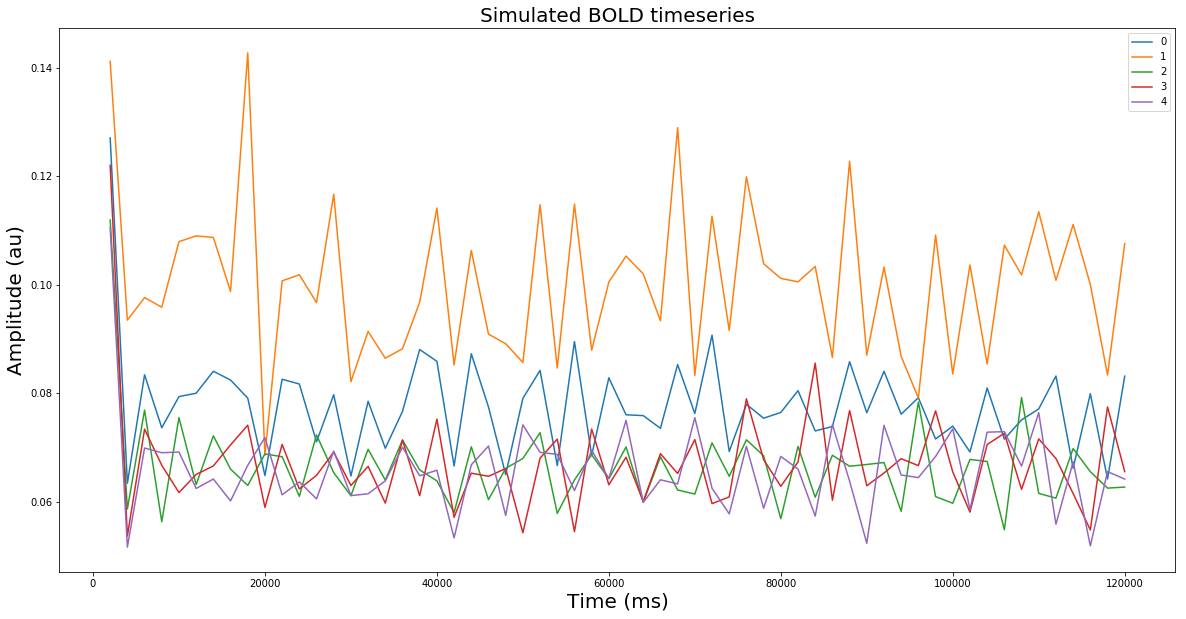

In [28]:
# Set the parameter of the resting state simulation

#numpy.random.seed(1028)
# Try a different random seed.

if BOLD == True:
    sim = simulator.Simulator(model=MODEL,
                            connectivity=con,
                            coupling=coupling.Linear(a=0.096),
                            integrator=integrators.EulerStochastic(dt=0.1,noise=noise.Additive(nsig=0.000013,random_stream=np.random.RandomState(RandState))),
                            monitors=(monitors.Bold(period=2e3),
                                      monitors.TemporalAverage(period=1e3)),
                            simulation_length=1.2e6,
                            #initial_conditions=[1.8,1.8,1.8,1.8,1.8]
                            ).configure()
    # Run the resting state simulation
    (bold_time, bold_data), _ = sim.run()

    # Display the simulated bold timeseries
    plt.subplots()
    plt.plot(bold_time,bold_data[:,0,:,0])
    plt.xlabel('Time (ms)', fontsize=20)
    plt.ylabel('Amplitude (au)', fontsize=20)
    plt.title('Simulated BOLD timeseries', fontsize=20)
    plt.legend(('0','1','2','3','4'))

# No Monitors 
else:

  sim = simulator.Simulator(model=MODEL,
                          connectivity=con,
                          coupling=coupling.Linear(a=0.096),
                          integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=0.000013,random_stream=np.random.RandomState(RandState))),
                          simulation_length=1.2e6).configure()
  # Run the resting state simulation
  awer = sim.run()
  bold_time = awer[0][0]
  bold_data = awer[0][1]

  # Display the simulated non-bold timeseries
# Display the simulated non-bold timeseries
  plt.subplots()
  plt.plot(bold_time,bold_data[:,0,:,0])
  plt.xlabel('Time (ms)', fontsize=20)
  plt.ylabel('Amplitude (au)', fontsize=20)
  plt.title('Simulated non-BOLD timeseries', fontsize=20)
  plt.legend(('0','1','2','3','4'))

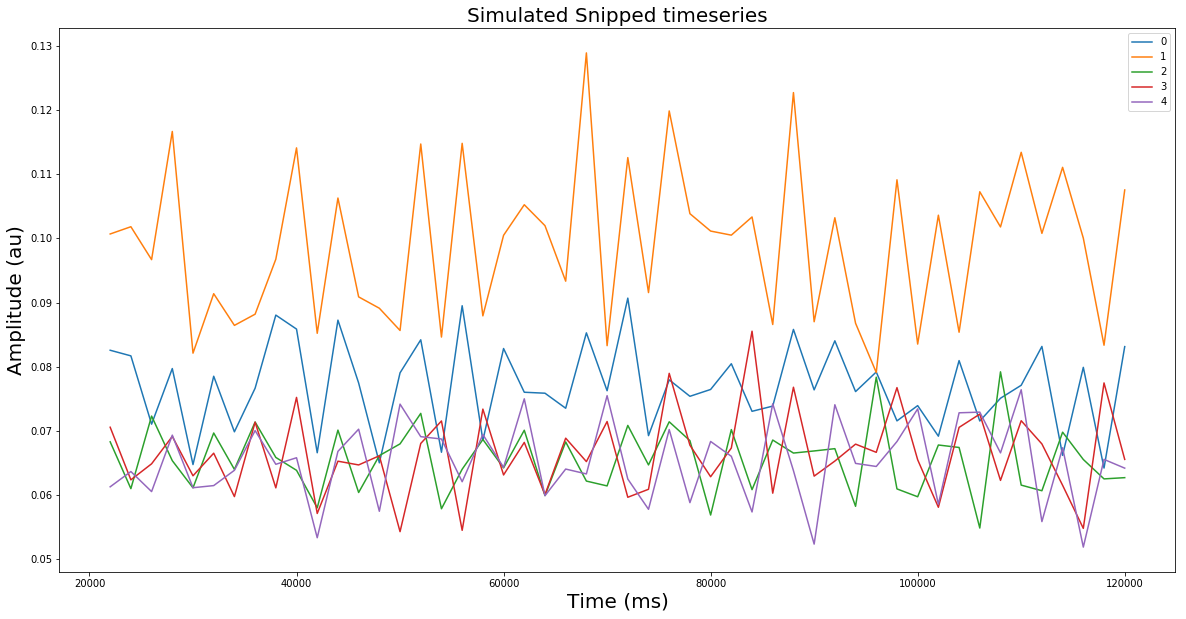

In [29]:
# Display the simulated snipped timeseries
plt.subplots()
plt.plot(bold_time[Snip:3000],bold_data[Snip:3000,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated Snipped timeseries', fontsize=20)
plt.legend(('0','1','2','3','4'))

In [30]:
# Functional Connectivity Matrix. 

# We note that this is a static analysis.  More advanced version would be a DYnamic version with windowing.

# Convert Simulation output into a form usable by Numpy.
TSeriesMatrix = np.empty((bold_data.shape[2], bold_data.shape[0]-Snip))
#Matrix = []

for i in range(bold_data.shape[2]):
    TSeriesMatrix[i] = bold_data[Snip:,0,i].flatten()

# Functional Conenctivity MAtrix = Pearson Correlation.

FCM = np.corrcoef(TSeriesMatrix)
FCM

array([[ 1.        ,  0.51455806,  0.20041611, -0.09791756,  0.07997517],
       [ 0.51455806,  1.        ,  0.0612922 ,  0.1639398 ,  0.02495869],
       [ 0.20041611,  0.0612922 ,  1.        , -0.08075542,  0.03537587],
       [-0.09791756,  0.1639398 , -0.08075542,  1.        ,  0.25891027],
       [ 0.07997517,  0.02495869,  0.03537587,  0.25891027,  1.        ]])

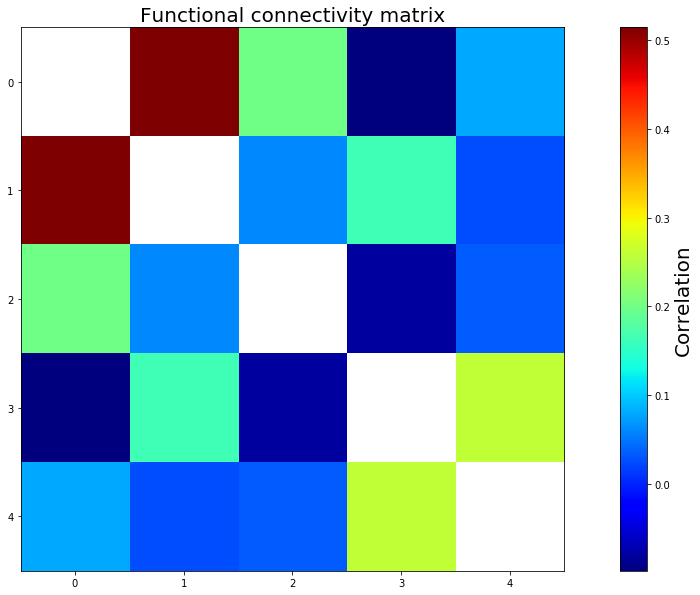

In [31]:
# Plot Matrix
# Set diagonals to NaN
FCM1 = FCM
np.fill_diagonal(FCM1,np.nan)

cs=plt.imshow(FCM1, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

In [32]:
# Comparing SC Vs FC with Spearman Correlation

# Grab Upper triangles
FCM_Upper = FCM[np.triu_indices(FCM.shape[0], k = 1)]
SCM_Upper = con.weights[np.triu_indices(con.weights.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
SCorr

SpearmanrResult(correlation=0.7977240352174655, pvalue=0.005691829882963575)

Text(0.05,0.95,u'SpearmanrResult(correlation=0.7977240352174655, pvalue=0.005691829882963575)')

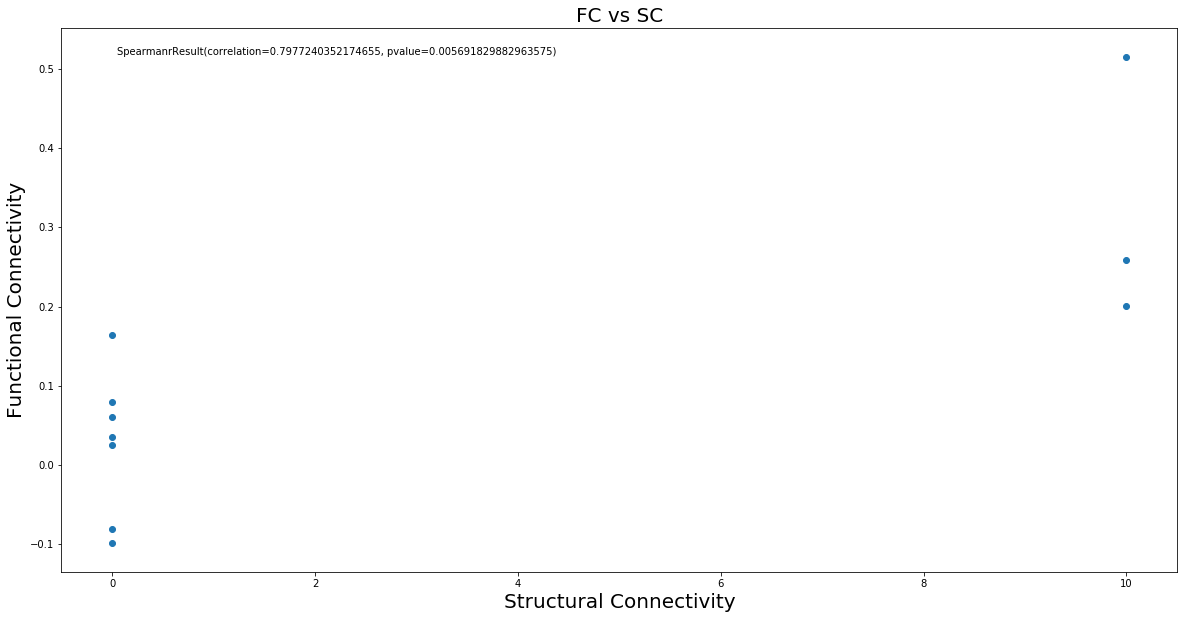

In [33]:
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('Structural Connectivity', fontsize=20)
plt.ylabel('Functional Connectivity', fontsize=20)
plt.title('FC vs SC', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')

In [34]:
# Export the simulation
np.savetxt("do-not-track\\" + name + "_TSM.csv", TSeriesMatrix, delimiter=",")
np.savetxt("do-not-track\\" + name + "_Time.csv", bold_time, delimiter = ",")
np.savetxt("do-not-track\\" + name + "_FCM.csv", FCM, delimiter = ",")
np.savetxt("do-not-track\\" + name + "_Scorr.csv", SCorr, delimiter = ",")